First let's import data in a dataframe.

In [1]:
import pandas as pd


url = 'https://stats.bis.org/api/v2/data/dataflow/BIS/WS_XRU/1.0/D.XM.EUR.A?format=csv'

data = pd.read_csv(url)
data = data[['CURRENCY', 'TIME_PERIOD', 'OBS_VALUE']].dropna()
data['TIME_PERIOD'] = pd.to_datetime(data['TIME_PERIOD'])
data.head()

,CURRENCY,TIME_PERIOD,OBS_VALUE
0,EUR,1974-06-28,0.828947
1,EUR,1974-07-01,0.828322
2,EUR,1974-07-02,0.828837
3,EUR,1974-07-03,0.826228
4,EUR,1974-07-04,0.830006


Then visualize the time series to forecast.

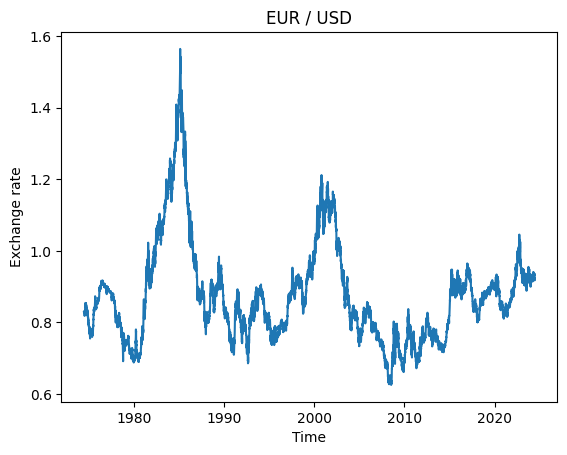

In [2]:
import matplotlib.pyplot as plt


plt.plot(data['TIME_PERIOD'], data['OBS_VALUE'])
plt.xlabel('Time')
plt.ylabel('Exchange rate')
plt.title('EUR / USD')
plt.show()

Get a common time grid for the two time series.

In [3]:
time_grid = data['TIME_PERIOD'].drop_duplicates()

print(f'Length of timeseries: {len(data)}')

Length of timeseries: 12728


Define constant for the sequence length of the forecasting model input.

In [4]:
INPUT_LENGTH = 64

Define a PyTorch Dataset and Dataloader for our timeseries forecasting problem.

In [5]:
from itertools import filterfalse
import random
from typing import Tuple

import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset


class ExchangeTimeSeries(Dataset):

    def __init__(self, data: pd.DataFrame):
        super().__init__()
        self.data = data
        self.timeseries_mean = torch.tensor(0)
        self.timeseries_std = torch.tensor(1)

    def __len__(self) -> int:
        return len(self.data) - INPUT_LENGTH

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, torch.Tensor]:
        # Input sequences
        X = self.data['OBS_VALUE'].iloc[i: i + INPUT_LENGTH].values.T
        X = torch.tensor(X.astype(np.float32))
        # Output values
        y = self.data['OBS_VALUE'].iloc[i + INPUT_LENGTH]
        y = torch.tensor(y.astype(np.float32))
        # Normalize
        X = (X - self.timeseries_mean) / self.timeseries_std
        return X, y

    def infer_mean_and_std(self) -> Tuple[torch.Tensor, torch.Tensor]:
        timeseries_mean = torch.tensor(
            self.data['OBS_VALUE'].mean().astype('float32'))
        timeseries_std = torch.tensor(
            self.data['OBS_VALUE'].std().astype('float32'))
        return timeseries_mean, timeseries_std

    def set_mean_and_std(self, timeseries_mean: torch.Tensor,
                         timeseries_std: torch.Tensor):
        self.timeseries_mean = timeseries_mean
        self.timeseries_std = timeseries_std


# Tests

def test_exchangetimeseries(dataset: ExchangeTimeSeries):
    i = random.randrange(len(dataset))
    X, y = dataset[i]
    m, std = dataset.infer_mean_and_std()
    assert X.size() == torch.Size([INPUT_LENGTH])
    assert y.size() == torch.Size([])
    assert torch.isnan(X).any().item() == False
    assert torch.isnan(y).any().item() == False
    assert m.size() == torch.Size([]) and std.size() == torch.Size([])

def test_dataloader(dataloader: DataLoader):
    for X, y in dataloader:
        assert X.size() == torch.Size([32, INPUT_LENGTH])
        assert y.size() == torch.Size([32])
        break

dataset = ExchangeTimeSeries(data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

test_exchangetimeseries(dataset)
test_dataloader(dataloader)

Define neural net model: transformer encoder and linear layer.

In [6]:
from torch import nn
from tqdm import tqdm


class TransformerForecaster(nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_input = nn.Linear(1, 128)
        transformer = nn.TransformerEncoderLayer(128, 4, batch_first=True)
        self.positional_encoding = nn.Parameter(self._get_positional_encoding(),
                                                requires_grad=False)
        self.transformer_stack = nn.TransformerEncoder(transformer,
                                                       num_layers=6)
        self.flatten = nn.Flatten()
        self.linear_output = nn.Linear(INPUT_LENGTH * 128, 1)
        # Checkpoint
        self.checkpoint = {
            'train_loss_history': [],
            'val_loss_history': [],
            'epochs': 0,
            'best_val_loss': float('inf'),
            'best_epoch': 0,
            'patience_counter': 0,
        }

    def _get_positional_encoding(self) -> torch.Tensor:
        position = torch.arange(0, INPUT_LENGTH).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, 128, 2)
                             * -(torch.log(torch.tensor(10000.0)) / 128))
        positional_encoding = torch.zeros(INPUT_LENGTH, 128)
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        return positional_encoding.unsqueeze(0)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = X.unsqueeze(2)  # Add feature axis
        X = self.linear_input(X)
        X = X + self.positional_encoding
        X = self.transformer_stack(X)
        X = self.flatten(X)
        X = self.linear_output(X)
        X = X.squeeze()  # Remove feature axis
        return X

    def train_one_epoch(
        self,
        dataloader: DataLoader,
        loss_fn: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
    ) -> Tuple[torch.optim.Optimizer, list]:
        self.train()
        loss_history = []
        pbar = tqdm(dataloader, desc='Training', unit='batch')
        for X, y in pbar:
            y_pred = self(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            loss_history.append(loss.item())
            pbar.set_postfix_str(f'loss={loss.item():>8f}')
            del loss
            optimizer.step()
            optimizer.zero_grad()
        return optimizer, loss_history

    def train_many_epochs(
        self,
        dataloader_train: DataLoader,
        dataloader_val: DataLoader,
        loss_fn: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        n_epoch: int,
        patience: int
    ):
        epoch = self.checkpoint['epochs'] + 1
        for epoch in range(epoch, epoch + n_epoch):
            print(f'-- Epoch {epoch} --')
            if self.early_stopping(patience):
                print('Early stopping!')
                break
            optimizer, loss_history = self.train_one_epoch(
                dataloader_train, loss_fn, optimizer)
            val_loss = self.evaluate(dataloader_val, loss_fn)
            print(f'Validation loss: {val_loss:>8f}')
            self.update_checkpoint(optimizer, epoch, loss_history, val_loss)
            torch.save(self.checkpoint, 'checkpoint.pt')

    def evaluate(
        self,
        dataloader: DataLoader,
        loss_fn: torch.nn.Module,
    ) -> float:
        self.eval()
        pbar = tqdm(dataloader, desc='Evaluation', unit='batch')
        mean_loss = 0
        with torch.no_grad():
            for X, y in pbar:
                y_pred = self(X)
                loss = loss_fn(y_pred, y)
                mean_loss += loss.item() / len(dataloader)
                pbar.set_postfix_str(f'loss={loss.item():>8f}')
        return mean_loss

    def early_stopping(self, patience: int) -> bool:
        if self.checkpoint['epochs'] == 0:
            return False
        val_loss = self.checkpoint['val_loss_history'][-1]
        if self.checkpoint['best_val_loss'] < val_loss:
            self.checkpoint['patience_counter'] += 1
        else:
            self.checkpoint['patience_counter'] = 0
        return patience <= self.checkpoint['patience_counter']

    def update_checkpoint(
        self,
        optimizer: torch.optim.Optimizer,
        epoch: int,
        train_loss_history: list,
        val_loss: float
    ):
        self.checkpoint['model_state_dict'] = self.state_dict()
        self.checkpoint['optimizer_state_dict'] = optimizer.state_dict()
        self.checkpoint['train_loss_history'] += train_loss_history
        self.checkpoint['val_loss_history'] += [val_loss] * \
            len(train_loss_history)
        self.checkpoint['epochs'] += 1
        if val_loss < self.checkpoint['best_val_loss']:
            self.checkpoint['best_model_state_dict'] = self.state_dict()
            self.checkpoint['best_val_loss'] = val_loss
            self.checkpoint['best_epoch'] = epoch

    def predict(self, dataloader: DataLoader) -> Tuple[
            torch.Tensor, torch.Tensor]:
        self.eval()
        y_full = []  # Actual values
        y_pred_full = []  # Predicted values
        pbar = tqdm(dataloader, desc='Prediction', unit='batch')
        with torch.no_grad():
            for X, y in pbar:
                y_pred = self(X)
                y_full.append(y)
                y_pred_full.append(y_pred)
        return torch.cat(y_full), torch.cat(y_pred_full)


# Test

def test_transformerforecaster(model: TransformerForecaster,
                               dataloader: DataLoader):
    X, y = next(iter(dataloader))
    y_pred = model(X)
    assert y_pred.size() == torch.Size([32])

model = TransformerForecaster()

test_transformerforecaster(model, dataloader)

In [7]:
n_param = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {n_param} parameters')

The model has 3566593 parameters


Split training, validation, and test data.

In [8]:
# Training
data_train = data.loc[data['TIME_PERIOD'] < '2023-01-01']

# Validation
data_val = data.loc[('2023-01-01' <= data['TIME_PERIOD']) &
                    (data['TIME_PERIOD'] < '2024-01-01')]
data_val = pd.concat([data_train.iloc[-INPUT_LENGTH:], data_val])

# Test
data_test = data.loc['2024-01-01' <= data['TIME_PERIOD']]
data_test = pd.concat([data_val.iloc[-INPUT_LENGTH:], data_test])

dataset_train = ExchangeTimeSeries(data_train)
dataset_val = ExchangeTimeSeries(data_val)
dataset_test = ExchangeTimeSeries(data_test)

Set mean and std for each dataset for normalization.

In [9]:
m, std = dataset_train.infer_mean_and_std()

dataset_train.set_mean_and_std(m, std)
dataset_val.set_mean_and_std(m, std)
dataset_test.set_mean_and_std(m, std)

dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=32, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

Define loss function (L1) and optimizer (Adam).

In [10]:
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)

Run training and save trained model.

In [11]:
import os

if os.path.exists('checkpoint.pt'):
    checkpoint = torch.load('checkpoint.pt')
    print('Checkpoint loaded!')
    model.load_state_dict(checkpoint['best_model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.checkpoint = checkpoint

model.train_many_epochs(dataloader_train, dataloader_val, loss_fn,
                        optimizer, 30, 3)

-- Epoch 1 --


Evaluation: 100%|██████████| 8/8 [00:02<00:00,  3.51batch/s, loss=0.080593]


Validation loss: 0.088457
-- Epoch 2 --


Evaluation: 100%|██████████| 8/8 [00:02<00:00,  3.50batch/s, loss=0.050458]


Validation loss: 0.054917
-- Epoch 3 --


Evaluation: 100%|██████████| 8/8 [00:02<00:00,  3.33batch/s, loss=0.022499]


Validation loss: 0.026851
-- Epoch 4 --


Evaluation: 100%|██████████| 8/8 [00:03<00:00,  2.41batch/s, loss=0.020560]


Validation loss: 0.017848
-- Epoch 5 --


Evaluation: 100%|██████████| 8/8 [00:02<00:00,  3.48batch/s, loss=0.027428]


Validation loss: 0.024508
-- Epoch 6 --


Evaluation: 100%|██████████| 8/8 [00:02<00:00,  3.52batch/s, loss=0.040421]


Validation loss: 0.039366
-- Epoch 7 --


Evaluation: 100%|██████████| 8/8 [00:02<00:00,  3.43batch/s, loss=0.005617]


Validation loss: 0.006496
-- Epoch 8 --


Evaluation: 100%|██████████| 8/8 [00:03<00:00,  2.45batch/s, loss=0.047557]


Validation loss: 0.049053
-- Epoch 9 --


Evaluation: 100%|██████████| 8/8 [00:02<00:00,  3.50batch/s, loss=0.005954]


Validation loss: 0.006523
-- Epoch 10 --


Evaluation: 100%|██████████| 8/8 [00:02<00:00,  3.54batch/s, loss=0.010973]

Validation loss: 0.013812
-- Epoch 11 --
Early stopping!


In [12]:
model = TransformerForecaster()
checkpoint = torch.load('checkpoint.pt')
model.load_state_dict(checkpoint['best_model_state_dict'])

<All keys matched successfully>

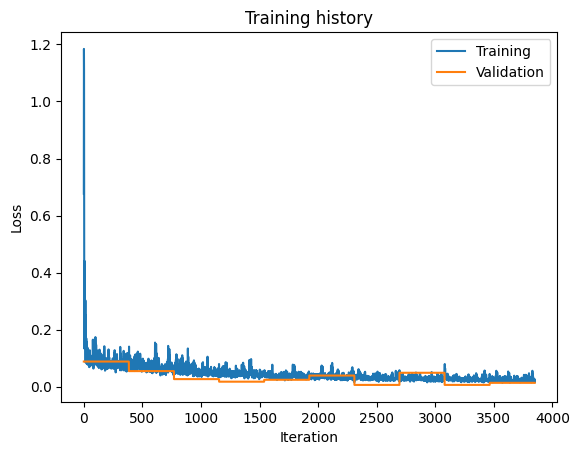

In [13]:
plt.plot(checkpoint['train_loss_history'], label='Training')
plt.plot(checkpoint['val_loss_history'], label='Validation')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training history')
plt.legend()
plt.show()

Infer predictions.

In [14]:
y_val, y_val_pred = model.predict(dataloader_val)
y_val, y_val_pred = y_val.numpy(), y_val_pred.numpy()
y_test, y_test_pred = model.predict(dataloader_test)
y_test, y_test_pred = y_test.numpy(), y_test_pred.numpy()

Prediction: 100%|██████████| 4/4 [00:01<00:00,  3.85batch/s]


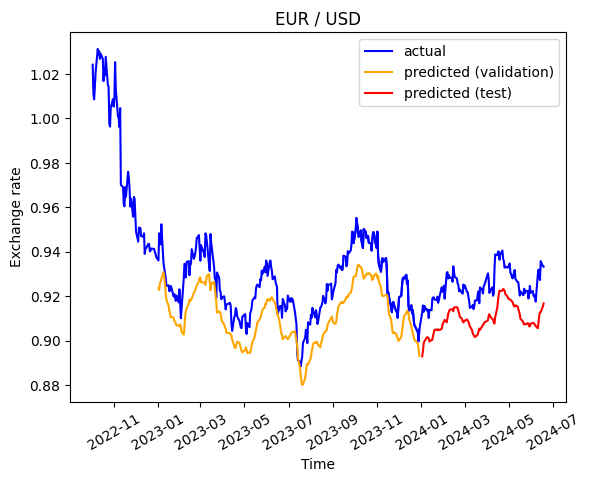

In [20]:
data_val['PRED_VALUE'] = np.concatenate((np.array([np.nan] * INPUT_LENGTH),
                                         y_val_pred))
data_test['PRED_VALUE'] = np.concatenate((np.array([np.nan] * INPUT_LENGTH),
                                          y_test_pred))

plt.plot(data_val['TIME_PERIOD'], data_val['OBS_VALUE'],
         color='blue', label='actual')
plt.plot(data_test['TIME_PERIOD'], data_test['OBS_VALUE'],
         color='blue')
plt.plot(data_val['TIME_PERIOD'], data_val['PRED_VALUE'],
         color='orange', label='predicted (validation)')
plt.plot(data_test['TIME_PERIOD'], data_test['PRED_VALUE'],
         color='red', label='predicted (test)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Exchange rate')
plt.title('EUR / USD')
plt.xticks(rotation=30)
plt.show()